# 1. Process Nodule Dataset

## Summary

* Load scans and convert to pixels
* Process image by normalizing, then removing everything outside of the lung tissue
* Generate nodule masks by loading nodule coordiates from list3.2 csv file and using the cellmagicwand tool over that coordinate

In [ ]:
import sys
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# uaktualnij poniższą ścieżkę
path_nb = r'/content/drive/My Drive/'
sys.path.append(path_nb)

Mounted at /content/drive


In [ ]:
# D:\anaconda3\python.exe D:\anaconda3\cwp.py D:\anaconda3 D:\anaconda3\python.exe D:\anaconda3\Scripts\jupyter-notebook-script.py "G:/PP/LungNoduleDetectionClassification"

In [ ]:
!pip install -U scikit-image

     |████████████████████████████████| 29.2MB 153kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scikit-image 0.16.2
    Uninstalling scikit-image-0.16.2:
      Successfully uninstalled scikit-image-0.16.2


In [ ]:
!pip install pydicom

     |████████████████████████████████| 1.9MB 11.2MB/s 


In [ ]:
#EDIT HERE##############################


#string:
num_start = 121
num_end = 150
str_start = str(num_start).rjust(4, '0')
str_end = str(num_end).rjust(4, '0')

#File paths
# metadatapath="LIDC/LIDC-IDRI_MetaData_old.csv"
metadatapath = "/content/drive/MyDrive/LIDC/metadata_test.csv"
list32path = "/content/drive/MyDrive/LIDC/list3.2.csv"
DOIfolderpath ='/content/drive/MyDrive/LIDC-IDRI/'
outfolder = '/content/drive/MyDrive/out/LungNoduleDetectionClassification/'+str_start+'_'+str_end+'/'
datafolder = outfolder+'processeddata'



# from '/content/drive/MyDrive/Colab Notebooks/LungNoduleDetectionClassification/cell_magic_wand' import cell_magic_wand as cmw
sys.path.append(os.path.abspath("/content/drive/MyDrive/Colab Notebooks/LungNoduleDetectionClassification/"))
import cell_magic_wand as cmw

########################################





import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# import dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time

from skimage import measure, morphology
#from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from sklearn.cluster import KMeans
from skimage.transform import resize
from skimage.draw import circle
# from skimage.draw import disk




In [ ]:
#Load nodules locations
nodulelocations=pd.read_csv(list32path)

#For test
nodulelocations=nodulelocations.drop(nodulelocations[nodulelocations['case']>num_end].index)
nodulelocations=nodulelocations.reset_index()
nodulelocations=nodulelocations.drop(nodulelocations[nodulelocations['case']<num_start].index)
nodulelocations=nodulelocations.reset_index()
# print(nodulelocations)
nodulelocations


,level_0,index,case,scan,roi,volume,eq. diam.,x loc.,y loc.,slice no.,Unnamed: 8,nodIDs,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15
0,337,337,121,3000776,1,145.36,6.524,350,213,114,NaN,Nodule 003,2,IL057_197158,MI014_20381,NaN,NaN,NaN
1,338,338,121,3000776,2,1660.58,14.692,287,166,117,NaN,MI014_20377,Nodule 001,IL057_197155,0,NaN,NaN,NaN
2,339,339,122,3000695,1,107.41,5.898,110,347,86,NaN,MI014_14696,IL057_196978,0,Nodule 001,NaN,NaN,NaN
3,340,340,123,3000648,1,127.86,6.250,366,340,151,NaN,IL057_168520,1,NaN,NaN,NaN,NaN,NaN
4,341,341,124,3,1,108.34,5.915,181,321,29,NaN,135005,115269,6,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,460,460,149,4,6,125.12,6.205,329,407,90,NaN,135716,115201,9,NaN,NaN,NaN,NaN
124,461,461,149,4,7,57.98,4.802,153,398,71,NaN,115213,NaN,NaN,NaN,NaN,NaN,NaN
125,462,462,149,4,8,57.98,4.802,206,396,93,NaN,135717,NaN,NaN,NaN,NaN,NaN,NaN
126,463,463,150,3185,1,2852.61,17.596,154,291,12,NaN,3141,13012,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Load metadata
meta=pd.read_csv(metadatapath)
meta=meta.drop(meta[meta['Modality']!='CT'].index)
meta=meta.reset_index()

#For test
meta=meta.drop(meta[meta['Subject ID']>'LIDC-IDRI-'+str_end].index)
meta=meta.drop(meta[meta['Subject ID']<'LIDC-IDRI-'+str_start].index)
meta=meta.reset_index()
# print(meta)

meta

,level_0,index,Series UID,Collection,3rd Party Analysis,Data Description URI,Subject ID,Study UID,Study Description,Study Date,Series Description,Manufacturer,Modality,SOP Class Name,SOP Class UID,Number of Images,File Size,File Location,Download Timestamp
0,120,239,1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896...,LIDC-IDRI,NaN,https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX,LIDC-IDRI-0122,1.3.6.1.4.1.14519.5.2.1.6279.6001.140459664666...,NaN,01.01.2000,NaN,GE MEDICAL SYSTEMS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,119,59.77 MB,.\LIDC-IDRI\LIDC-IDRI-0122\01-01-2000-66616\30...,2021-03-25T20:35:24.775
1,121,242,1.3.6.1.4.1.14519.5.2.1.6279.6001.225515255547...,LIDC-IDRI,NaN,https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX,LIDC-IDRI-0121,1.3.6.1.4.1.14519.5.2.1.6279.6001.189280790286...,NaN,01.01.2000,NaN,GE MEDICAL SYSTEMS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,277,139.30 MB,.\LIDC-IDRI\LIDC-IDRI-0121\01-01-2000-41529\30...,2021-03-25T20:35:59.322
2,122,243,1.3.6.1.4.1.14519.5.2.1.6279.6001.103115201714...,LIDC-IDRI,NaN,https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX,LIDC-IDRI-0123,1.3.6.1.4.1.14519.5.2.1.6279.6001.222363923835...,NaN,01.01.2000,NaN,GE MEDICAL SYSTEMS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,236,118.51 MB,.\LIDC-IDRI\LIDC-IDRI-0123\01-01-2000-95866\30...,2021-03-25T20:36:13.02
3,123,244,1.3.6.1.4.1.14519.5.2.1.6279.6001.112767175295...,LIDC-IDRI,NaN,https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX,LIDC-IDRI-0124,1.3.6.1.4.1.14519.5.2.1.6279.6001.121477207174...,CAP,01.01.2000,Recon 2 C-A-P,GE MEDICAL SYSTEMS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,117,58.98 MB,.\LIDC-IDRI\LIDC-IDRI-0124\01-01-2000-CAP-9366...,2021-03-25T20:36:13.976
4,124,247,1.3.6.1.4.1.14519.5.2.1.6279.6001.454273545863...,LIDC-IDRI,NaN,https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX,LIDC-IDRI-0126,1.3.6.1.4.1.14519.5.2.1.6279.6001.319426861743...,NaN,01.01.2000,NaN,GE MEDICAL SYSTEMS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,137,68.83 MB,.\LIDC-IDRI\LIDC-IDRI-0126\01-01-2000-94320\30...,2021-03-25T20:36:49.921
5,125,250,1.3.6.1.4.1.14519.5.2.1.6279.6001.316393351033...,LIDC-IDRI,NaN,https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX,LIDC-IDRI-0125,1.3.6.1.4.1.14519.5.2.1.6279.6001.274533538808...,NaN,01.01.2000,NaN,GE MEDICAL SYSTEMS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,238,119.53 MB,.\LIDC-IDRI\LIDC-IDRI-0125\01-01-2000-61676\30...,2021-03-25T20:36:59.778
6,126,251,1.3.6.1.4.1.14519.5.2.1.6279.6001.229343399861...,LIDC-IDRI,NaN,https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX,LIDC-IDRI-0127,1.3.6.1.4.1.14519.5.2.1.6279.6001.195975724868...,NaN,01.01.2000,ChestRoutine 3.0 B31f,SIEMENS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,117,58.73 MB,.\LIDC-IDRI\LIDC-IDRI-0127\01-01-2000-00442\33...,2021-03-25T20:37:06.811
7,127,254,1.3.6.1.4.1.14519.5.2.1.6279.6001.176030616406...,LIDC-IDRI,NaN,https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX,LIDC-IDRI-0129,1.3.6.1.4.1.14519.5.2.1.6279.6001.336271942450...,CT ANGIO CHEST WWO C,01.01.2000,BOTTOM TO TOP,GE MEDICAL SYSTEMS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,253,127.74 MB,.\LIDC-IDRI\LIDC-IDRI-0129\01-01-2000-CT ANGIO...,2021-03-25T20:37:50.634
8,128,256,1.3.6.1.4.1.14519.5.2.1.6279.6001.241717018262...,LIDC-IDRI,NaN,https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX,LIDC-IDRI-0128,1.3.6.1.4.1.14519.5.2.1.6279.6001.276357014804...,NaN,01.01.2000,NaN,GE MEDICAL SYSTEMS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,257,129.15 MB,.\LIDC-IDRI\LIDC-IDRI-0128\01-01-2000-25676\30...,2021-03-25T20:37:58.4
9,129,258,1.3.6.1.4.1.14519.5.2.1.6279.6001.975426625618...,LIDC-IDRI,NaN,https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX,LIDC-IDRI-0131,1.3.6.1.4.1.14519.5.2.1.6279.6001.178055839088...,NaN,01.01.2000,NaN,GE MEDICAL SYSTEMS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,197,98.96 MB,.\LIDC-IDRI\LIDC-IDRI-0131\01-01-2000-20316\30...,2021-03-25T20:39:09.225


In [ ]:
#Get folder names of CT data for each patient
patients=[DOIfolderpath+meta['Subject ID'][i] for i in range(len(meta))]

datfolder=[]

if os.name == 'nt': # Windows
    for i in range(0,len(meta)):
        for path in os.listdir(patients[i]):
            # print(patients[i]+'/'+path+'/'+(meta['File Location'][i]).split(os.sep)[4])
            if os.path.exists(patients[i]+'/'+path+'/'+(meta['File Location'][i]).split(os.sep)[4]):
                datfolder.append(patients[i]+'/'+path+'/'+(meta['File Location'][i]).split(os.sep)[4])
else:
    for i in range(0,len(meta)):
        for path in os.listdir(patients[i]):
            # print(patients[i]+'/'+path+'/'+(meta['File Location'][i]).split('\\')[4])
            if os.path.exists(patients[i]+'/'+path+'/'+(meta['File Location'][i]).split('\\')[4]):
                datfolder.append(patients[i]+'/'+path+'/'+(meta['File Location'][i]).split('\\')[4])



patients=datfolder
# len(datfolder)
patients

['/content/drive/MyDrive/LIDC-IDRI/LIDC-IDRI-0122/01-01-2000-66616/3000695.000000-41492',
 '/content/drive/MyDrive/LIDC-IDRI/LIDC-IDRI-0121/01-01-2000-41529/3000776.000000-23312',
 '/content/drive/MyDrive/LIDC-IDRI/LIDC-IDRI-0123/01-01-2000-95866/3000648.000000-68219',
 '/content/drive/MyDrive/LIDC-IDRI/LIDC-IDRI-0124/01-01-2000-CAP-93667/3.000000-Recon 2 C-A-P-11437',
 '/content/drive/MyDrive/LIDC-IDRI/LIDC-IDRI-0126/01-01-2000-94320/3000639.000000-58130',
 '/content/drive/MyDrive/LIDC-IDRI/LIDC-IDRI-0125/01-01-2000-61676/3000702.000000-08261',
 '/content/drive/MyDrive/LIDC-IDRI/LIDC-IDRI-0127/01-01-2000-00442/3318.000000-ChestRoutine  3.0  B31f-89892',
 '/content/drive/MyDrive/LIDC-IDRI/LIDC-IDRI-0129/01-01-2000-CT ANGIO CHEST WWO C-30279/2.000000-BOTTOM TO TOP-12518',
 '/content/drive/MyDrive/LIDC-IDRI/LIDC-IDRI-0128/01-01-2000-25676/3000740.000000-19144',
 '/content/drive/MyDrive/LIDC-IDRI/LIDC-IDRI-0131/01-01-2000-20316/3000694.000000-09852',
 '/content/drive/MyDrive/LIDC-IDRI/LID

In [ ]:
# Load the scans in given folder path
# code sourced from https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial

import pydicom


def load_scan(path):
#     print(path)
#     print(os.listdir(path))
    slices = [pydicom.dcmread(path + '/' + s, force=True) for s in os.listdir(path) if s.endswith('.dcm')]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]), reverse=True)
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

#convert to ndarray
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None
    
def segment_lung_mask(image, fill_lung_structures=True, dilate=False):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures==True:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
    
    if dilate==True:
        for i in range(binary_image.shape[0]):
            binary_image[i]=morphology.dilation(binary_image[i],np.ones([10,10]))
    return binary_image

patients[0]

'/content/drive/MyDrive/LIDC-IDRI/LIDC-IDRI-0122/01-01-2000-66616/3000695.000000-41492'

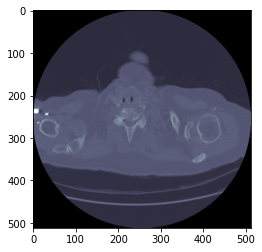

In [ ]:
import matplotlib.pyplot as plt
import pydicom
from pydicom.data import get_testdata_files
# filename = get_testdata_files("../LIDC-IDRI/LIDC-IDRI-0001/01-01-2000-30178/3000566.000000-03192/1-001.dcm")[0]
filename = DOIfolderpath+'LIDC-IDRI-0001/01-01-2000-30178/3000566.000000-03192' + '/' + '1-001.dcm'
ds = pydicom.dcmread(filename)
plt.imshow(ds.pixel_array, cmap=plt.cm.bone) 

# ds = dicom.read_file(filename)
# plt.imshow(ds.pixel_array, cmap=plt.cm.bone) 

# dicom.read_file('../LIDC-IDRI/LIDC-IDRI-0001/01-01-2000-30178/3000566.000000-03192' + '/' + '1-001.dcm')

In [ ]:
#Let's look at one of the patients

first_patient = load_scan(patients[0])
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

import scipy
# Show some slice in the middle
#data=scipy.ndimage.interpolation.zoom(first_patient_pixels[41],[200,200])
plt.figure()
plt.imshow(first_patient_pixels[42])
plt.annotate('', xy=(317, 367), xycoords='data',
             xytext=(0.5, 0.5), textcoords='figure fraction',
             arrowprops=dict(arrowstyle="->"))
#plt.savefig("images/test.png",dpi=300)
plt.show()



In [ ]:
def processimage(img):
    #function sourced from https://www.kaggle.com/c/data-science-bowl-2017#tutorial
    #Standardize the pixel values
    mean = np.nanmean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    #plt.hist(img.flatten(),bins=200)
    #plt.show()
    #print(thresh_img[366][280:450])
    middle = img[100:400,100:400] 
    mean = np.nanmean(middle)  
    max = np.max(img)
    min = np.min(img)
    #move the underflow bins
    img[img==max]=mean
    img[img==min]=mean
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.nanmean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image
    eroded = morphology.erosion(thresh_img,np.ones([4,4]))
    dilation = morphology.dilation(eroded,np.ones([10,10]))
    labels = measure.label(dilation)
    label_vals = np.unique(labels)
    #plt.imshow(labels)
    #plt.show()
    labels = measure.label(dilation)
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<475 and B[3]-B[1]<475 and B[0]>40 and B[2]<472:
            good_labels.append(prop.label)
    mask = np.ndarray([512,512],dtype=np.int8)
    mask[:] = 0
    #
    #  The mask here is the mask for the lungs--not the nodes
    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    #
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation
    return mask*img

def nodule_coordinates(nodulelocations,meta):
    slices=nodulelocations["slice no."][nodulelocations.index[nodulelocations["case"]==int(meta["Subject ID"][-4:])]]
    xlocs=nodulelocations["x loc."][nodulelocations.index[nodulelocations["case"]==int(meta["Subject ID"][-4:])]]
    ylocs=nodulelocations["y loc."][nodulelocations.index[nodulelocations["case"]==int(meta["Subject ID"][-4:])]]
    nodulecoord=[]
    for i in range(len(slices)):
        nodulecoord.append([slices.values[i]-1,xlocs.values[i]-1,ylocs.values[i]-1])
    return nodulecoord

In [ ]:
#Generate and save nodule images for all samples

pathname = outfolder+"images/"
if not (os.path.exists(pathname)):
    os.makedirs(pathname)

# for i in range(0,len(patients)):
#     print(i)
#     first_patient = load_scan(patients[i])
#     first_patient_pixels = get_pixels_hu(first_patient)
#     nodcord=nodule_coordinates(nodulelocations,meta.loc[i])
#     for j in range(len(nodcord)):
#         #plt.imsave("images/"+meta['Patient Id'].loc[i]+"slice"+str(slice)+".png",first_patient_pixels[slice])
#         plt.figure()
#         plt.imshow(first_patient_pixels[nodcord[j][0]])
#         plt.annotate('', xy=(nodcord[j][1], nodcord[j][2]), xycoords='data',
#              xytext=(0.5, 0.5), textcoords='figure fraction',
#              arrowprops=dict(arrowstyle="->"))
#         imagename = meta['Subject ID'].loc[i]+"slice"+str(nodcord[j])+".png"
        
#         plt.savefig(pathname+'/'+imagename,dpi=300)
#         plt.close()


In [ ]:
from skimage.draw import disk

np.seterr('raise')

histplotsfolder = outfolder+"histplots/"
if not (os.path.exists(histplotsfolder)):
    os.makedirs(histplotsfolder)
    

if not (os.path.exists(datafolder)):
    os.makedirs(datafolder)

noduleimages=np.ndarray([len(nodulelocations)*3,512,512],dtype=np.float32)
nodulemasks=np.ndarray([len(nodulelocations)*3,512,512],dtype=np.bool)
nodulemaskscircle=np.ndarray([len(nodulelocations)*3,512,512],dtype=np.bool)
index=0
totaltime=50000
start_time=time.time()
elapsed_time=0
nodulemeanhu=[]
nonnodulemeanhu=[]
thresh=-500
for i in range(len(patients)):
    print("Processing patient#",i,"ETA:",(totaltime-elapsed_time)/3600,"hrs")
    coord=nodule_coordinates(nodulelocations,meta.iloc[i])
    if len(coord)>0:
        patient=load_scan(patients[i])
        patient_pix=get_pixels_hu(patient)
        radius=nodulelocations["eq. diam."][nodulelocations.index[nodulelocations["case"]==int(meta["Subject ID"][i][-4:])]]
        nodulemask=np.ndarray([len(coord),512,512],dtype=np.bool)
        for j,cord in enumerate(coord):
            segmented_mask_fill=segment_lung_mask(patient_pix,True,False)

            if radius.iloc[j]>5:
                #slice nodulecenter-1
                noduleimages[index]=processimage(patient_pix[cord[0]-1])
                nodulemasks[index]=cmw.cell_magic_wand(-patient_pix[int(cord[0])-1],[int(cord[2]),int(cord[1])],2,int(radius.iloc[j])+2)
#                 rr,cc=circle(int(cord[2]),int(cord[1]),int(radius.iloc[j]))
                rr,cc=disk((int(cord[2]),int(cord[1])),int(radius.iloc[j]))
                imgcircle = np.zeros((512, 512), dtype=np.int16)
                imgcircle[rr,cc]=1
                nodulepixcircle=imgcircle*patient_pix[cord[0]-1]
                nodulepixcircle[nodulepixcircle<thresh]=0
                nodulepixcircle[nodulepixcircle!=0]=1
                nodulemaskscircle[index]=nodulepixcircle.astype(np.bool)
                
                nodulepix=nodulemasks[index]*patient_pix[cord[0]-1]
                nodulepix[nodulepix<thresh]=0
                nodulepix[nodulepix!=0]=1
                nodulemasks[index]=nodulepix.astype(np.bool)

                index+=1
                
                #slice nodulecenter
                noduleimages[index]=processimage(patient_pix[cord[0]])
                nodulemasks[index]=cmw.cell_magic_wand(-patient_pix[int(cord[0])],[int(cord[2]),int(cord[1])],2,int(radius.iloc[j])+2)
                nodulepix=nodulemasks[index]*patient_pix[cord[0]]
                nodulepix[nodulepix<thresh]=0
                nodulepixcircle=imgcircle*patient_pix[cord[0]]
                nodulepixcircle[nodulepixcircle<thresh]=0
                
                # HU - Hounsfield unit               
                #get mean nodule HU value

                #get mean non-nodule HU value
                nonnodule=(nodulemasks[index].astype(np.int16)-1)*-1*segmented_mask_fill[cord[0]]*patient_pix[cord[0]]
                nonnodule[nonnodule<thresh]=0

                if len(nonnodule[nonnodule!=0]) == 0:
                  print("E-nonnodule: ")
                  print(index)
                  nonnodulemeanhu.append(np.nanmean(nonnodule))
                else:
                  nonnodulemeanhu.append(np.nanmean(nonnodule[nonnodule!=0]))

                # nonnodulemeanhu.append(np.nanmean(nonnodule[nonnodule!=0]))

                plt.figure()
                #plt.hist(nodulepix[nodulepix!=0].flatten(),bins=80, alpha=0.5, color='blue')
                plt.hist(nonnodule[nonnodule!=0].flatten(),bins=80, alpha=0.5, color='orange')
                plt.hist(nodulepixcircle[nodulepix!=0].flatten(),bins=80,alpha=0.5, color='green')
                plt.savefig(histplotsfolder+meta['Subject ID'].loc[i]+"slice"+str(cord)+".png",dpi=300)
                plt.close()

                if len(nodulepix[nodulepix!=0]) == 0:
                  print("E-nodulepix: ")
                  print(+index)
                  nodulemeanhu.append(np.nanmean(nodulepix))
                else:
                  nodulemeanhu.append(np.nanmean(nodulepix[nodulepix!=0]))



                # nodulemeanhu.append(np.nanmean(nodulepix[nodulepix!=0]))
                nodulepix[nodulepix!=0]=1
                nodulemasks[index]=nodulepix.astype(np.bool)
                nodulepixcircle[nodulepixcircle!=0]=1
                nodulemaskscircle[index]=nodulepixcircle.astype(np.bool)
                index+=1
                
                #slice nodulecenter+1
                noduleimages[index]=processimage(patient_pix[cord[0]+1])
                nodulemasks[index]=cmw.cell_magic_wand(-patient_pix[int(cord[0])+1],[int(cord[2]),int(cord[1])],2,int(radius.iloc[j])+2)
                nodulepix=nodulemasks[index]*patient_pix[cord[0]+1]
                nodulepix[nodulepix<thresh]=0
                nodulepix[nodulepix!=0]=1
                nodulemasks[index]=nodulepix.astype(np.bool)
                nodulepixcircle=imgcircle*patient_pix[cord[0]+1]
                nodulepixcircle[nodulepixcircle<thresh]=0
                nodulepixcircle[nodulepixcircle!=0]=1
                nodulemaskscircle[index]=nodulepixcircle.astype(np.bool)
                index+=1
    elapsed_time=time.time()-start_time
    totaltime=elapsed_time/(i+1)*len(patients)
np.save(datafolder+'/noduleimages_'+str_start+'_'+str_end+'.npy',noduleimages)
np.save(datafolder+'/nodulemasks_'+str_start+'_'+str_end+'.npy',nodulemasks)
np.save(datafolder+'/nodulemaskscircle_'+str_start+'_'+str_end+'.npy',nodulemaskscircle)

Processing patient# 0 ETA: 13.88888888888889 hrs
Processing patient# 1 ETA: 0.06932036876678467 hrs
Processing patient# 2 ETA: 0.6197203032506837 hrs
Processing patient# 3 ETA: 0.6943525947464837 hrs
Processing patient# 4 ETA: 0.7767791484296321 hrs
Processing patient# 5 ETA: 0.7070378239949544 hrs
Processing patient# 6 ETA: 0.727500562314634 hrs
Processing patient# 7 ETA: 0.653816849617731 hrs
Processing patient# 8 ETA: 0.7948281394110785 hrs
Processing patient# 9 ETA: 0.7787502665431412 hrs
E-nonnodule: 
76
Processing patient# 10 ETA: 0.7303285992741585 hrs
E-nodulepix: 
100
E-nodulepix: 
103
E-nodulepix: 
106
E-nodulepix: 
109
Processing patient# 11 ETA: 0.7210921664430638 hrs
Processing patient# 12 ETA: 0.7045011887175067 hrs
E-nodulepix: 
121
E-nodulepix: 
124
E-nodulepix: 
127
E-nodulepix: 
133
E-nodulepix: 
136
Processing patient# 13 ETA: 0.6755992078781128 hrs
Processing patient# 14 ETA: 0.6273513545829152 hrs
Processing patient# 15 ETA: 0.5735308775725187 hrs
E-nonnodule: 
178

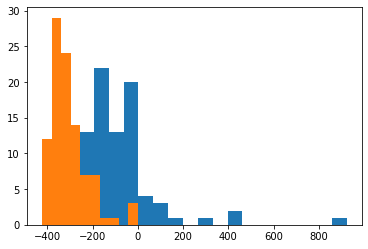

In [ ]:
#Exploratory analysis
plt.hist(nodulemeanhu, bins=20)
plt.hist(nonnodulemeanhu)
plt.show()

In [ ]:
np.nanmean([2,4,6])

4.0

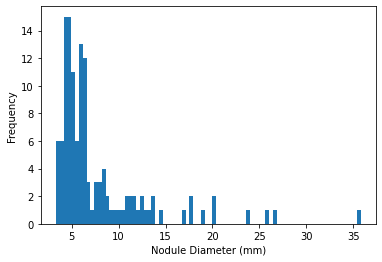

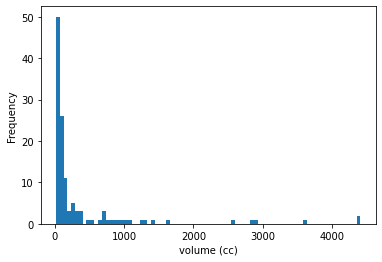

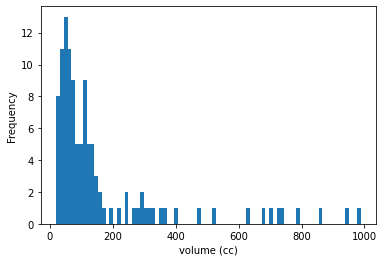

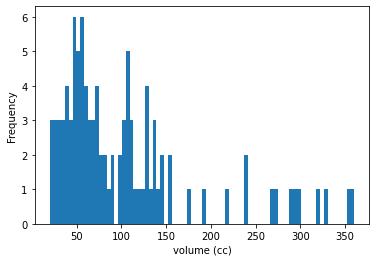

In [ ]:
plt.hist(nodulelocations['eq. diam.'], bins=80)
plt.xlabel("Nodule Diameter (mm)")
plt.ylabel("Frequency")
plt.show()

plt.hist(nodulelocations['volume'].loc[nodulelocations['volume']<6000], bins=80)
plt.xlabel("volume (cc)")
plt.ylabel("Frequency")
plt.show()
plt.hist(nodulelocations['volume'].loc[nodulelocations['volume']<1000], bins=80)
plt.xlabel("volume (cc)")
plt.ylabel("Frequency")
plt.show()
plt.hist(nodulelocations['volume'].loc[nodulelocations['volume']<400], bins=80)
plt.xlabel("volume (cc)")
plt.ylabel("Frequency")
plt.show()

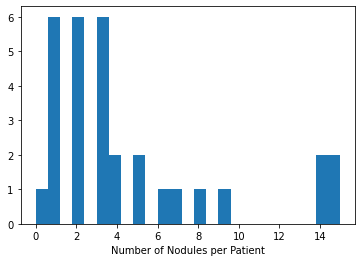

In [ ]:
nodcount=[]
for i in range(len(patients)):
    coord=nodule_coordinates(nodulelocations,meta.iloc[i])
    nodcount.append(len(coord))
    
plt.hist(nodcount, bins=25)
plt.xlabel("Number of Nodules per Patient")
plt.show()

0


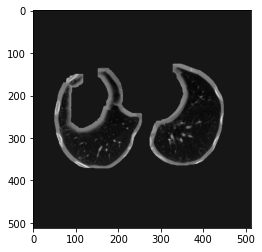

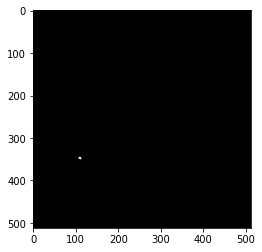

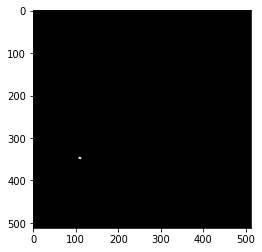

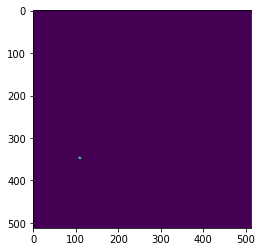

------------------------------------------
1


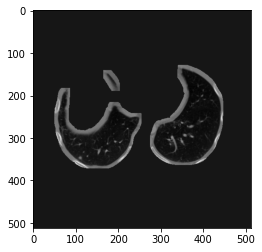

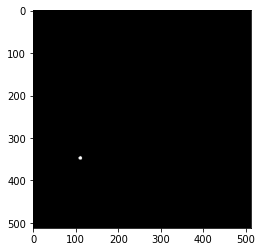

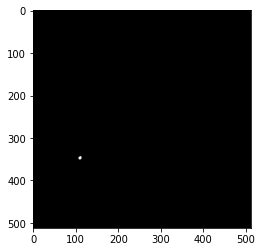

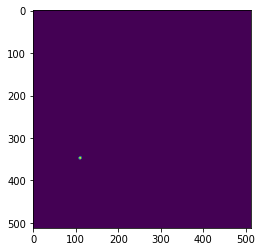

------------------------------------------
2


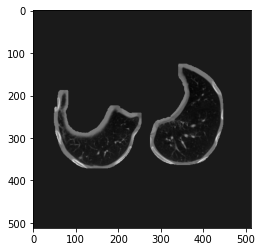

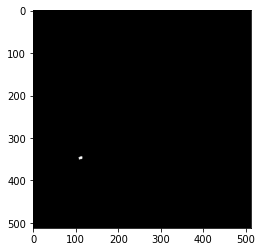

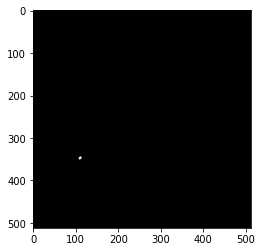

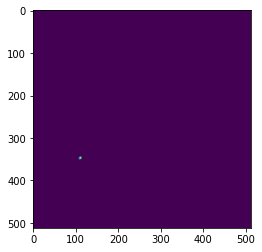

------------------------------------------
3


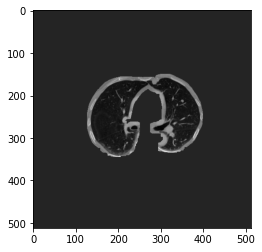

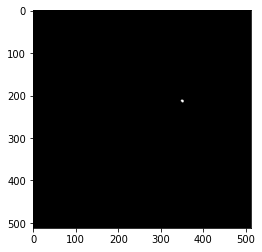

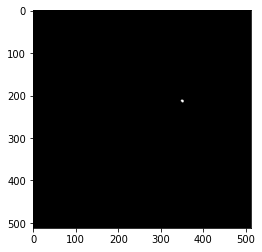

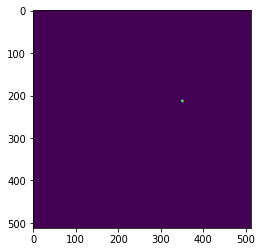

------------------------------------------
4


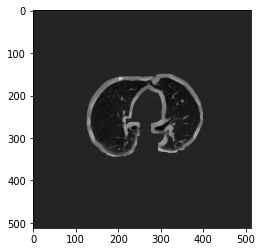

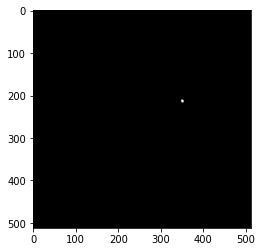

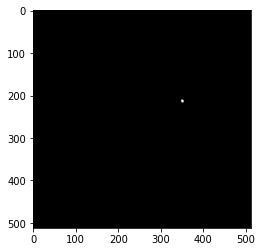

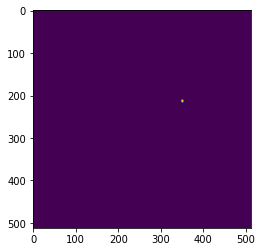

------------------------------------------
5


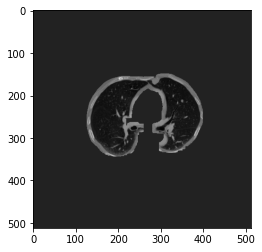

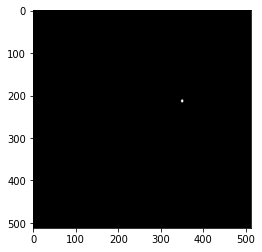

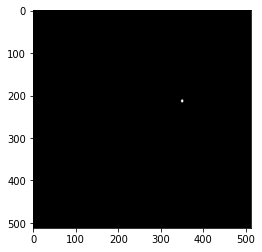

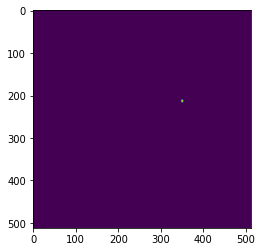

------------------------------------------
6


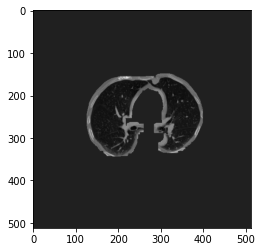

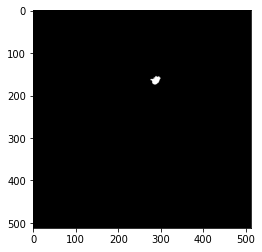

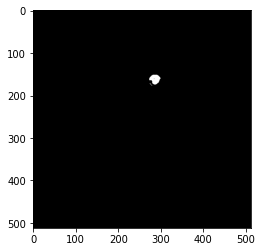

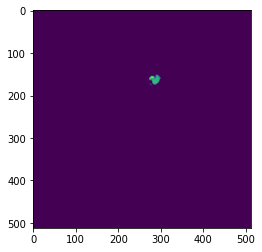

------------------------------------------
7


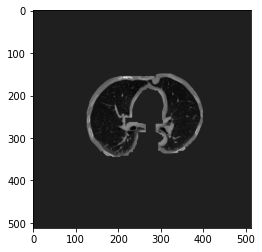

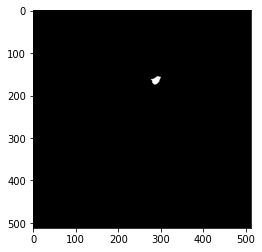

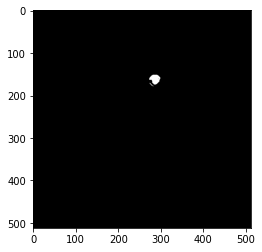

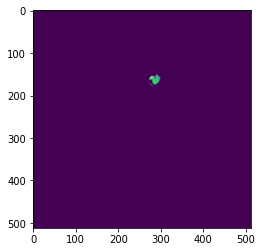

------------------------------------------
8


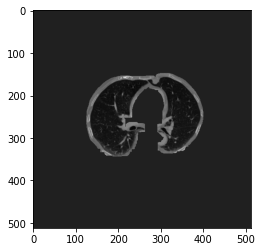

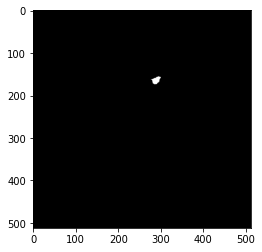

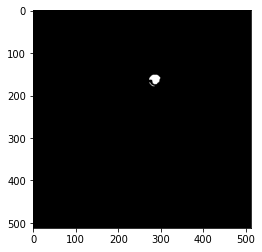

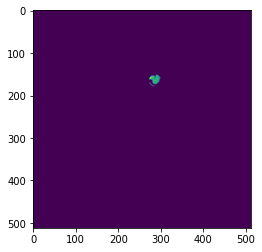

------------------------------------------
9


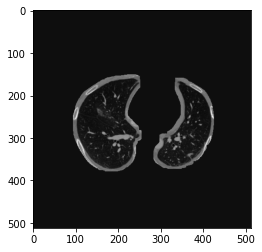

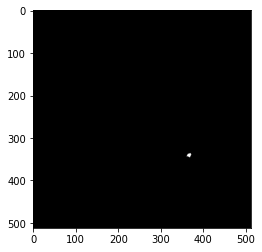

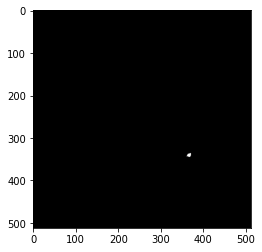

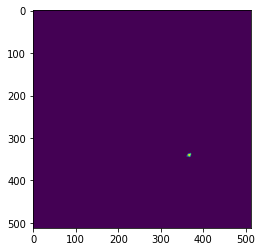

------------------------------------------


In [ ]:

# for i in range(noduleimages.shape[0]):
for i in range(10):
    print(i)
    plt.imshow(noduleimages[i],cmap="gray")
    plt.show()
    plt.imshow(nodulemasks[i], cmap="gray")
    plt.show()
    plt.imshow(nodulemaskscircle[i], cmap="gray")
    plt.show()
    plt.imshow(noduleimages[i]*nodulemaskscircle[i])
    plt.show()
    print("------------------------------------------")

